# C6.W3.NYT: Predicting series with complicated seasonality

Performed by Alexander Manushin 14.02.2019

# Part 1. Data preprocessing

## 0. mport libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt

%matplotlib inline

## 1. Creating of regression features

Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

### 1.1 Choosing the zone (region)

Let's take the region contains the Empire State Building

In [3]:
region = 1231

### 1.2 Preprocessing of aggegation data of trips sum per hour in the ___ region

In [4]:
# read raw csv, filter by region
def read_region_filter(year, month, region):
    #read trip_data and regions
    if month < 10: month = '0'+str(month)
    file_name = 'yellow_tripdata_'+str(year)+'-'+str(month)+'.csv'
    data = pd.read_csv(file_name)
    regions = pd.read_csv('regions.csv', ';')
    west, east, south, north = regions[regions.region == region].drop(['region'], axis = 1).values[0]
    # filter only region trips
    data = data[(data.pickup_longitude > west)&(data.pickup_longitude < east)&
                (data.pickup_latitude > south)&(data.pickup_latitude < north)]
    return data

In [5]:
def data_clearer(data):
    #zero_duration:
    data = data[data.tpep_dropoff_datetime != data.tpep_pickup_datetime]
    #zero_passenger:
    data = data[data.passenger_count != 0]
    #zero_distance:
    data = data[data.trip_distance != 0]
    return data

In [6]:
def arrregator(data):
    #transform tpep_pickup_datetime to datetime dtype
    data.tpep_pickup_datetime = data.tpep_pickup_datetime.apply(pd.to_datetime)
    # delete minutes and seconds from tpep_pickup_datetime column in data
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: x.replace(second=0))
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: x.replace(minute=0))
    #data aggregation: count trips by hours
    data['trips']=[1]*len(data)
    aggr_data = data.groupby('tpep_pickup_datetime').count()[['trips']].reset_index()
    return aggr_data

In [7]:
def save_aggr_data(aggr_data, year, month, region):
    if month < 10: month = '0'+str(month)
    file_name = 'aggr_yellow_tripdata_'+str(year)+'-'+str(month)+'-region-'+str(region)+'.csv'
    aggr_data.to_csv(file_name, index=False)
    print 'File {} saved'.format(file_name)

In [8]:
def full_data_preprocess(year, month, region):
    data = read_region_filter(year, month, region)
    data = data_clearer(data)
    aggr_data = arrregator(data)
    save_aggr_data(aggr_data, year, month, region)

In [64]:
%%time
for month in range(1,13):
    full_data_preprocess(2015, month, region)

File aggr_yellow_tripdata_2015-01-region-1231.csv saved
File aggr_yellow_tripdata_2015-02-region-1231.csv saved
File aggr_yellow_tripdata_2015-03-region-1231.csv saved
File aggr_yellow_tripdata_2015-04-region-1231.csv saved
File aggr_yellow_tripdata_2015-05-region-1231.csv saved
File aggr_yellow_tripdata_2015-06-region-1231.csv saved
File aggr_yellow_tripdata_2015-07-region-1231.csv saved
File aggr_yellow_tripdata_2015-08-region-1231.csv saved
File aggr_yellow_tripdata_2015-09-region-1231.csv saved
File aggr_yellow_tripdata_2015-10-region-1231.csv saved
File aggr_yellow_tripdata_2015-11-region-1231.csv saved
File aggr_yellow_tripdata_2015-12-region-1231.csv saved
Wall time: 22min 28s


In [65]:
%%time
for month in range(1,6):
    full_data_preprocess(2016, month, region)

File aggr_yellow_tripdata_2016-01-region-1231.csv saved
File aggr_yellow_tripdata_2016-02-region-1231.csv saved
File aggr_yellow_tripdata_2016-03-region-1231.csv saved
File aggr_yellow_tripdata_2016-04-region-1231.csv saved
File aggr_yellow_tripdata_2016-05-region-1231.csv saved
Wall time: 8min 58s


In [14]:
%%time
#concat all month
year = 2015
total_data = pd.DataFrame(columns=['tpep_pickup_datetime', 'trips'])
for month in range(1,13):
    if month < 10: month = '0'+str(month)
    file_name = 'aggr_yellow_tripdata_'+str(year)+'-'+str(month)+'-region-'+str(region)+'.csv'
    aggr_data = pd.read_csv(file_name)
    total_data = total_data.append(aggr_data, ignore_index=True)
    #print '{} hours that is {} days in {} month'.format(len(aggr_data), len(aggr_data)/24., str(month))

for month in range(1,6):
    year = 2016
    if month < 10: month = '0'+str(month)
    file_name = 'aggr_yellow_tripdata_'+str(year)+'-'+str(month)+'-region-'+str(region)+'.csv'
    aggr_data = pd.read_csv(file_name)
    total_data = total_data.append(aggr_data, ignore_index=True)

# change datatime dtype and index 
total_data.tpep_pickup_datetime = total_data.tpep_pickup_datetime.apply(pd.to_datetime)
total_data.index = total_data.tpep_pickup_datetime
print total_data.shape[0]

12394
Wall time: 6.1 s


In [15]:
#create the datetime range
import datetime
datetime1 = '2015-01-01 00:00:00'
datetime2 = '2016-05-31 23:00:00'
start = datetime.datetime.strptime(datetime1, '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime(datetime2, '%Y-%m-%d %H:%M:%S')
step = datetime.timedelta(hours=1)
date_range = []
while start <= end:
    date_range.append(start)
    start += step

In [17]:
#create datetime range df
total_data_all_hours = pd.DataFrame(index = date_range)
#concat datetime range df with data
total_data_all_hours = pd.concat([total_data_all_hours, total_data], axis=1, join_axes=[total_data_all_hours.index])
total_data_all_hours.tpep_pickup_datetime = total_data_all_hours.index
total_data_all_hours.trips.fillna(0, inplace=True)
total_data_all_hours.reset_index(drop=True, inplace=True)
total_data_all_hours.head()
print total_data_all_hours.info()
#save to csv
total_data_all_hours.to_csv('tripdata_2015-01_2016_05-region_1231.csv', index=False)
print 'File tripdata_2015-01_2016_05-region_1231.csv saved'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12408 entries, 0 to 12407
Data columns (total 2 columns):
tpep_pickup_datetime    12408 non-null datetime64[ns]
trips                   12408 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 193.9 KB
None
File tripdata_2015-01_2016_05-region_1231.csv saved


### 1.3 Plot the time series

Text(0,0.5,"Trips' quantity")

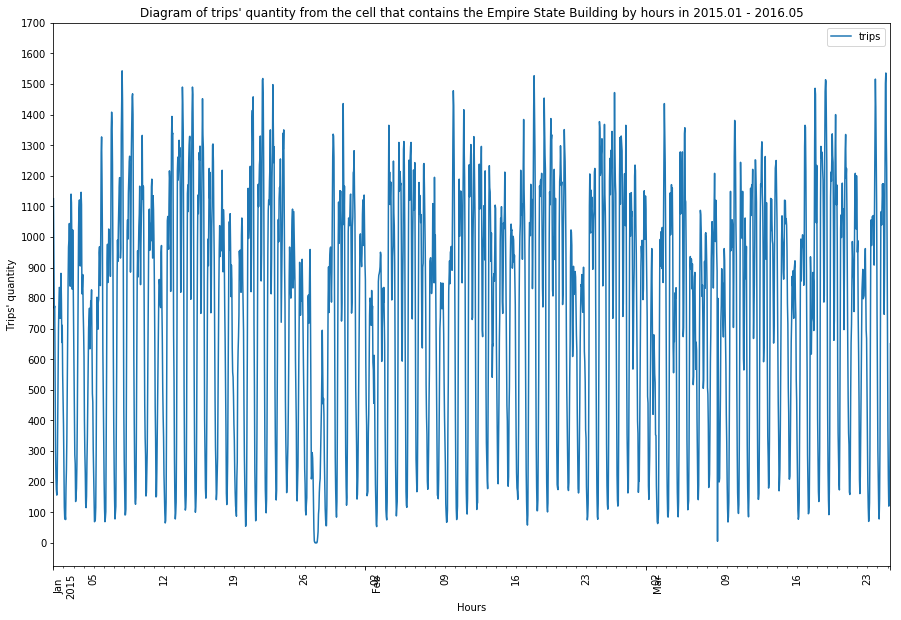

In [13]:
yticks = range(0,1750,100)
#xticks = pd.date_range(total_data_all_hours.tpep_pickup_datetime.min().date(), total_data_all_hours.tpep_pickup_datetime.max().date(), 365)
total_data_all_hours[:2000].plot(x = 'tpep_pickup_datetime', y = 'trips', figsize=(15, 10), 
    yticks=yticks, legend=True, rot=90)
plt.title("Diagram of trips' quantity from the cell that contains the Empire State Building by hours in 2015.01 - 2016.05")
plt.xlabel('Hours')
plt.ylabel("Trips' quantity")